# Conv-model with Quantile-Transform

## Import packages

In [1]:
import glob
import os
import sys

sys.path.append('..')

In [2]:
import torch
import torch.nn as nn

import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt

from astropy.io import fits

from tqdm import tqdm

from inverse_problem import HinodeME
from inverse_problem import SpectrumDataset, PregenSpectrumDataset, make_loader
from inverse_problem.nn_inversion.posthoc import compute_metrics, open_param_file, plot_params, plot_pred_vs_refer, plot_analysis_hist2d
from inverse_problem.nn_inversion.posthoc import open_spectrum_data, real_spectra, plot_spectrum, plot_model_spectrum, read_spectrum_for_refer
from inverse_problem.nn_inversion.transforms import normalize_output, inverse_transformation

from inverse_problem.nn_inversion.model_pi_mlp_conv import PIMLPConvNet
from inverse_problem.nn_inversion import conv1d_transform_rescale, normalize_spectrum


%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
from datetime import datetime
from pathlib import Path

model_name = 'qt_model'

current_time = str(datetime.now().strftime('%Y-%m-%d_%H-%M'))

save_path = '../' + model_name + '_' + current_time + '/'
Path(save_path).mkdir(parents=True, exist_ok=True)

save_path

'../qt_model_2022-04-15_16-41/'

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device.type)

cpu


## Dataset

In [5]:
filename = '../data/parameters_base.fits'
params = fits.open(filename)[0].data

## Data Filtering

In [6]:
def params_masked_rows(pars_arr):
    
    max_par_values = np.array([par_arr.max() for par_arr in pars_arr.T])
    min_par_values = np.array([par_arr.min() for par_arr in pars_arr.T])

    bool_arr = (min_par_values + 1e-3 < pars_arr) & (pars_arr < max_par_values - 1e-3)
    return np.all(bool_arr, axis=1)

def create_masked_array(pars_arr):
    rows_mask = params_masked_rows(pars_arr)
    array_mask = rows_mask[:, np.newaxis] | np.zeros_like(pars_arr, dtype=bool)
    return ma.masked_array(pars_arr, mask=~array_mask)

In [7]:
rows_mask_params = params_masked_rows(params)
filtered_params = params[rows_mask_params, :]

## Dataloader

In [8]:
factors, cont_scale = [1, 1000, 1000, 1000], 40000
angle_transformation, logB = False, False

transform_name = "conv1d_transform_rescale"

batch_size = 128

In [9]:
from sklearn.preprocessing import QuantileTransformer

qt = QuantileTransformer()
qt.fit(filtered_params)

QuantileTransformer()

In [10]:
qt.get_params(deep=True)

{'copy': True,
 'ignore_implicit_zeros': False,
 'n_quantiles': 1000,
 'output_distribution': 'uniform',
 'random_state': None,
 'subsample': 100000}

In [11]:
np.save(save_path + 'quantiles', qt.quantiles_)

In [12]:
train_loader, val_loader = make_loader(data_arr=filtered_params, transform_name=transform_name,
                                       factors=factors, cont_scale=cont_scale,
                                       logB=logB, angle_transformation=angle_transformation,
                                       QuantileTransformer=qt, batch_size=batch_size)

sample_batch = next(iter(train_loader))

print('Size of spectrum batch: ', sample_batch['X'][0].shape)
print('Size of cont batch: ', sample_batch['X'][1].shape)
print('Size of true params batch: ', sample_batch['Y'].shape)

print(f'\nNumber of batches for train: {len(train_loader)}, for validation: {len(val_loader)}')

Size of spectrum batch:  torch.Size([128, 4, 56])
Size of cont batch:  torch.Size([128, 1])
Size of true params batch:  torch.Size([128, 11])

Number of batches for train: 31243, for validation: 3472


## Model

In [13]:
model = PIMLPConvNet(n_blocks=6, in_dim=(4, 64, 64, 128, 128, 256), out_dim=(64, 64, 128, 128, 256, 256),
                     kernel_size=(3, 3, 3, 3, 3, 3), padding=(1, 1, 1, 1, 1, 1), activation='elu', dropout=0.05,
                     batch_norm=True, pool=(None, 'max', None, 'max', None, None), hidden_dims=(100, 100),
                     bottom_output=100, number_readout_layers=2, top_output=11)

In [14]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
model.to(device);

## Model Training

In [15]:
def fit_step(dataloader, max_steps=None):
    train_loss = 0.0
    train_it = 0
    if max_steps is None:
        max_steps = float('inf')
    total = min(max_steps, len(dataloader))

    with tqdm(desc="fit_batch", total=total, position=0, leave=True) as pbar_outer:
        for i, inputs in enumerate(dataloader):
            if i == total:
                break

            x = [inputs['X'][0].to(device), inputs['X'][1].to(device)]
            y = inputs['Y'].to(device)

            outputs = model(x)

            optimizer.zero_grad()
            
            loss = criterion(outputs, y)
            
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_it += 1

            if train_it % 10 == 0:
                pbar_outer.update(10)

        return train_loss / train_it


def eval_step(dataloader, max_steps=None):
    model.eval()
    val_loss = 0.0
    val_it = 0
    
    if max_steps is None:
        max_steps = float('inf')
    total = min(max_steps, len(dataloader))

    with tqdm(desc="val_batch", total=total, position=0, leave=True) as pbar_outer:
        for i, inputs in enumerate(dataloader):
            if i == total:
                break
                
            x = [inputs['X'][0].to(device), inputs['X'][1].to(device)]
            y = inputs['Y'].to(device)

            with torch.no_grad():
                outputs = model(x)
                
                loss = criterion(outputs, y)
                val_loss += loss.item()
                val_it += 1
                
            if val_it % 10 == 0:
                pbar_outer.update(10)
        return val_loss / val_it


def save_model(path, epoch, loss):
    """
    Args:
        path (str): path to save model to
        epoch (int): optional
        loss (float): optional, validation loss
    Returns:
    """
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss},
        path + model_name + '_' + f'ep{epoch}.pt')


def train(n_epoch, log_dir=None, path_to_save=None, max_steps=None):
    loss_history = []
    best_valid_loss = float('inf')

    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} val_loss {v_loss:0.4f}"

    with tqdm(desc="epoch", total=n_epoch, position=0, leave=True) as pbar_outer:
        for epoch in range(n_epoch):
            train_loss = fit_step(train_loader, max_steps=max_steps)
            val_loss = eval_step(val_loader, max_steps=max_steps)
            loss_history.append((train_loss, val_loss))
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch + 1, t_loss=train_loss, v_loss=val_loss))

            if path_to_save:
                if val_loss < best_valid_loss:
                    best_valid_loss = val_loss
                    save_model(path_to_save, epoch, val_loss)
            
            if log_dir:
                with open(os.path.join(log_dir, 'history_' + model_name + '_' + current_time + '.txt'), 'w') as f:
                    for i, item in enumerate(loss_history):
                        f.write(f"Train loss in epoch {i}: {item[0]: .4f}, val_loss: {item[1]:.4f}\n")

    return loss_history

In [16]:
num_epochs = 5

In [ ]:
%%time

history = train(n_epoch=num_epochs,
                log_dir=save_path,
                path_to_save=save_path)

epoch:  40%|████      | 2/5 [7:41:59<11:27:16, 13745.64s/it]


Epoch 002 train_loss: 0.0086 val_loss 0.0080


fit_batch:  57%|█████▋    | 17690/31243 [1:18:00<54:59,  4.11it/s]  

## Model Analysis

Два варианта:
- Оценка понимание моделью симуляции спектров из референсных значений, полученных обращением реальных спектров
- Оценка качество работы на реальных спектрах

In [ ]:
checkpoint_path = save_path + 'qt_model_ep4.pt'

model.load_state_dict(torch.load(checkpoint_path, map_location=device)['model_state_dict'])

### Реферер
Посмотрим что он из себя представляет (на самом деле база с параметрами и есть композиция нескольких рефереров)

Несколько примеров лежат подготовленные на гугл диске:
https://drive.google.com/drive/folders/1bv-KLMI67kiGNxlOjkJha2UmVggjV-sa?usp=sharing

In [ ]:
path_to_refer = '../data/hinode_source/20140926_170005.fits'

Можно с помощью функции сразу нормировать выходы так как это делается для сети, но посмотреть мы можем и сырые данные

In [ ]:
ref_unnorm, names = open_param_file(path_to_refer, normalize=False)
ref_unnorm_2d = ref_unnorm.reshape(-1, 11)

ref_shape = ref_unnorm.shape

print('\n', ref_shape)

In [ ]:
ref_2d = normalize_output(ref_unnorm_2d.copy(),
                          logB=logB,
                          angle_transformation=angle_transformation,
                          QuantileTransformer=qt)

ref = ref_2d.reshape(ref_shape).copy()

### Refer Filtering

In [ ]:
masked_ref_2d = create_masked_array(ref_2d)
masked_ref = masked_ref_2d.reshape(ref_shape)

masked_ref_unnorm_2d = create_masked_array(ref_unnorm_2d)
masked_ref_unnorm = masked_ref_unnorm_2d.reshape(ref_shape)

### Тестируем модель на симуляции данных из реферера

тут нам препроцессинг может упростить PregenDataset, можно и руками с помощью  BatchMe приготовить данные (он там и есть). Дальше надо загрузить 500k параметров и сделать симуляцию, поэтому работает это долго (в SpectrumDataset генерация во время обучения, поэтому надо только считать параметры и это быстро)

In [ ]:
%%time

transform = conv1d_transform_rescale(factors=factors, 
                                     angle_transformation=angle_transformation,
                                     cont_scale=cont_scale, logB=logB, QuantileTransformer=qt)

test_dataset = PregenSpectrumDataset(data_arr=masked_ref_unnorm_2d,
                                     transform=transform)

In [ ]:
inputs = test_dataset.samples
sim_x = [inputs['X'][0].to(device), inputs['X'][1].to(device)]
y = inputs['Y'].to(device)

In [ ]:
%%time

model.eval()
with torch.no_grad():
    predicted = model(sim_x)

In [ ]:
predicted = predicted.detach().cpu().numpy()
predicted_2d = predicted.reshape(-1, 11).copy()

In [ ]:
np.save(save_path + 'prediction_refer', predicted_2d)

In [ ]:
fe_names = names.copy()
fe_names = ['tr_' + fe_name for fe_name in fe_names]

In [32]:
compute_metrics(masked_ref_2d.data, predicted_2d,
                names=fe_names,
                save_path=save_path+model_name+'.csv', 
                mask=masked_ref_2d.mask)

,r2,mse,mae
tr_Field_Strength,0.9574,0.0034,0.0368
tr_Field_Inclination,0.9871,0.0013,0.0223
tr_Field_Azimuth,0.7659,0.0181,0.0630
tr_Doppler_Width,0.9734,0.0024,0.0352
tr_Damping,0.9747,0.0022,0.0333
tr_Line_Strength,0.9381,0.0050,0.0471
tr_Source_Function,0.9254,0.0049,0.0473
tr_Source_Function_Gradient,0.9798,0.0013,0.0233
tr_Doppler_Shift2,0.9703,0.0019,0.0251
tr_Stray_Light_Fill_Factor,0.8643,0.0112,0.0699


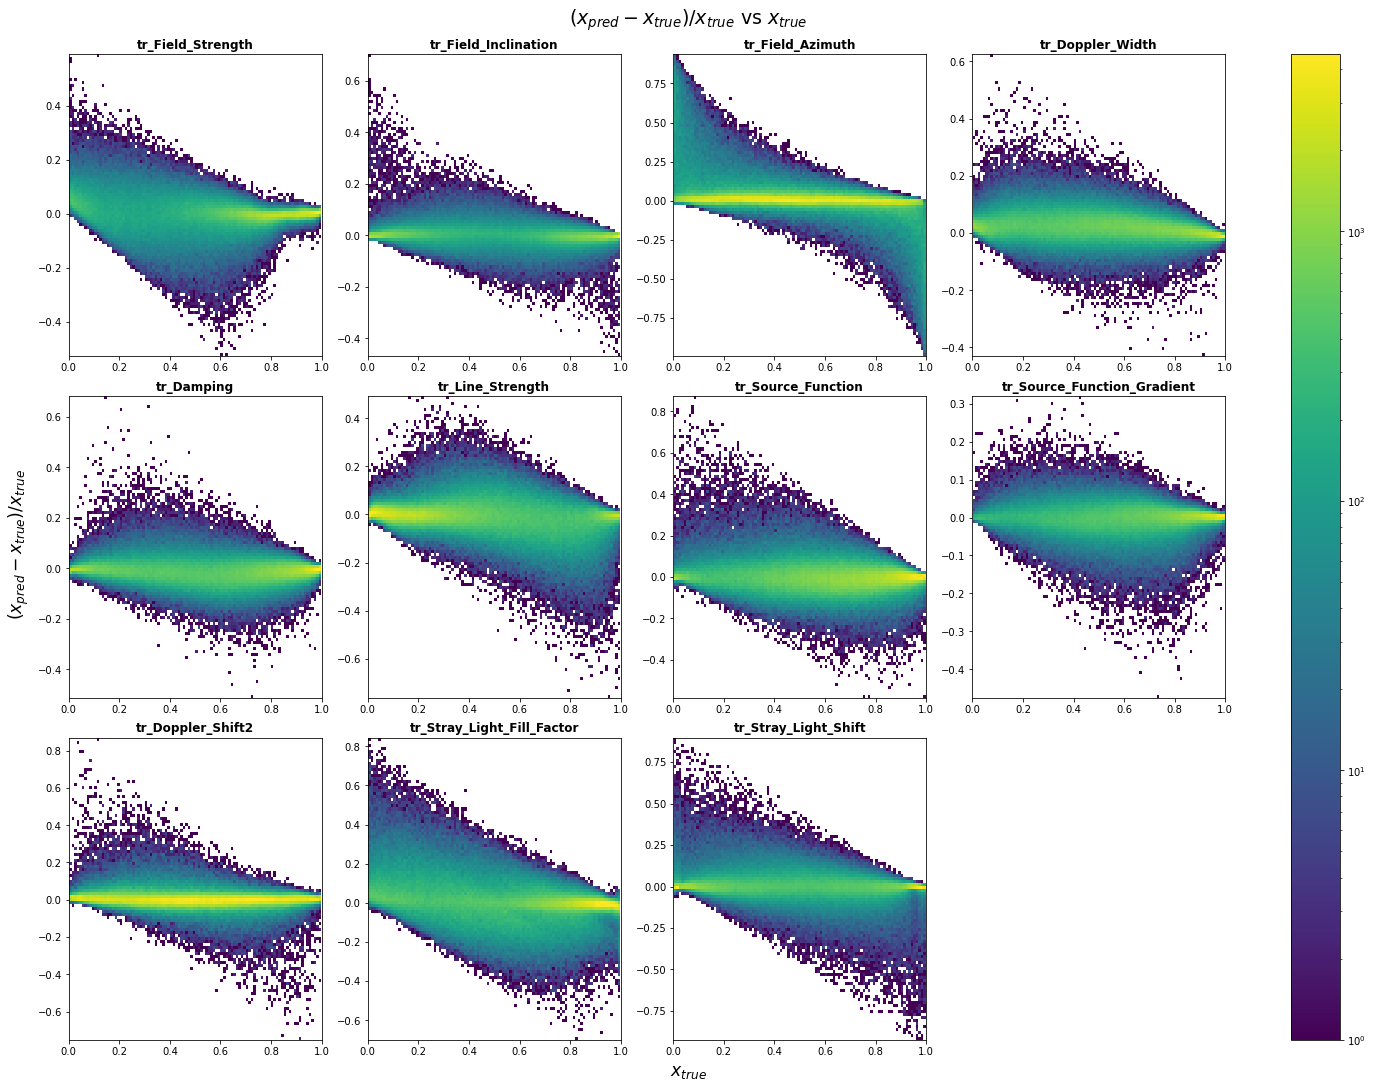

In [44]:
fig, axs = plot_analysis_hist2d(masked_ref_2d.data, predicted_2d, 
                                names=fe_names,
                                save_path=save_path+model_name+'_analysis_hist2d',
                                mask=masked_ref_2d.mask)

custom_xlim = (0, 1)
# custom_ylim = (-1, 1)
plt.setp(axs, xlim=custom_xlim)
# plt.setp(axs)

plt.show()

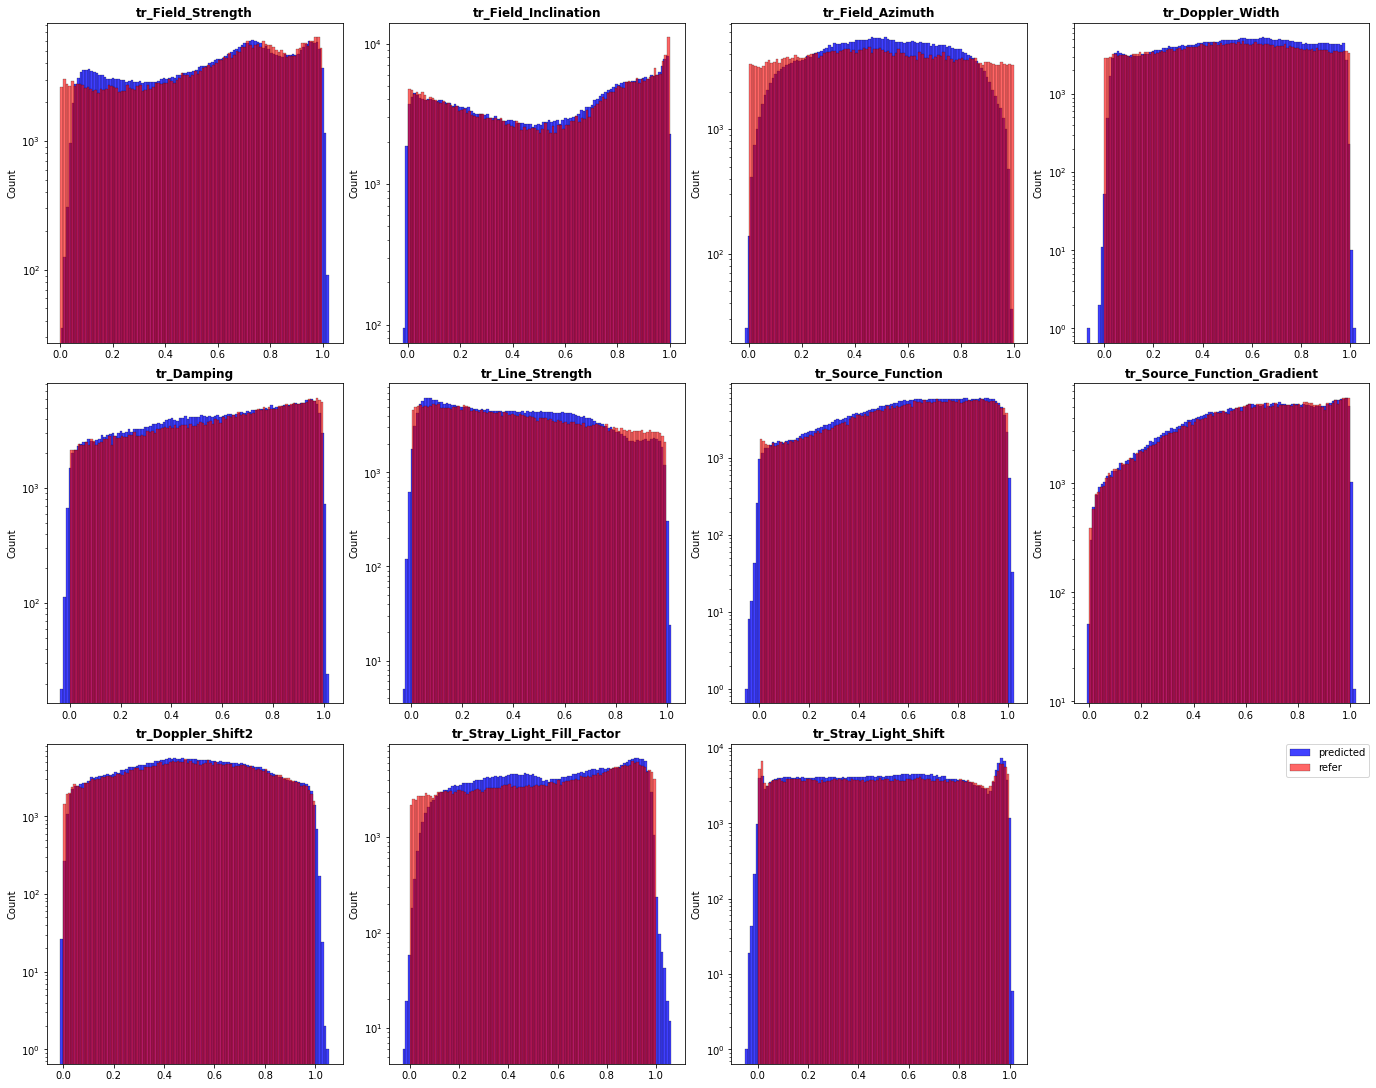

In [34]:
from inverse_problem.nn_inversion.posthoc import plot_hist_params_comparison

plot_hist_params_comparison(predicted_2d, masked_ref_2d.data, 
                            pars_names=fe_names,
                            save_path=save_path+model_name+'_comp_plot',
                            mask=masked_ref_2d.mask)

plt.show()

## Обратные преобразования параметров

In [45]:
predicted_2d_inv = qt.inverse_transform(predicted_2d)

In [71]:
np.save(save_path + 'predicted_refer_inv', predicted_2d_inv)

In [46]:
compute_metrics(masked_ref_unnorm_2d.data, predicted_2d_inv, 
                mask=masked_ref_2d.mask,
                save_path=save_path+model_name+'_inv' + '.csv')

,r2,mse,mae
Field Strength,0.8821,4.047811e+04,52.5401
Field Inclination,0.9837,2.196600e+01,2.9029
Field Azimuth,0.7651,5.843264e+02,11.3319
Doppler Width,0.9680,2.768500e+00,1.0805
Damping,0.9508,1.800000e-03,0.0241
Line Strength,0.8753,8.925100e+00,1.3287
S_0,0.9053,5.679413e+05,481.0259
S_1,0.9235,2.894025e+06,608.2934
Doppler Shift,0.9582,2.760000e-02,0.0872
Filling Factor,0.8924,6.100000e-03,0.0533


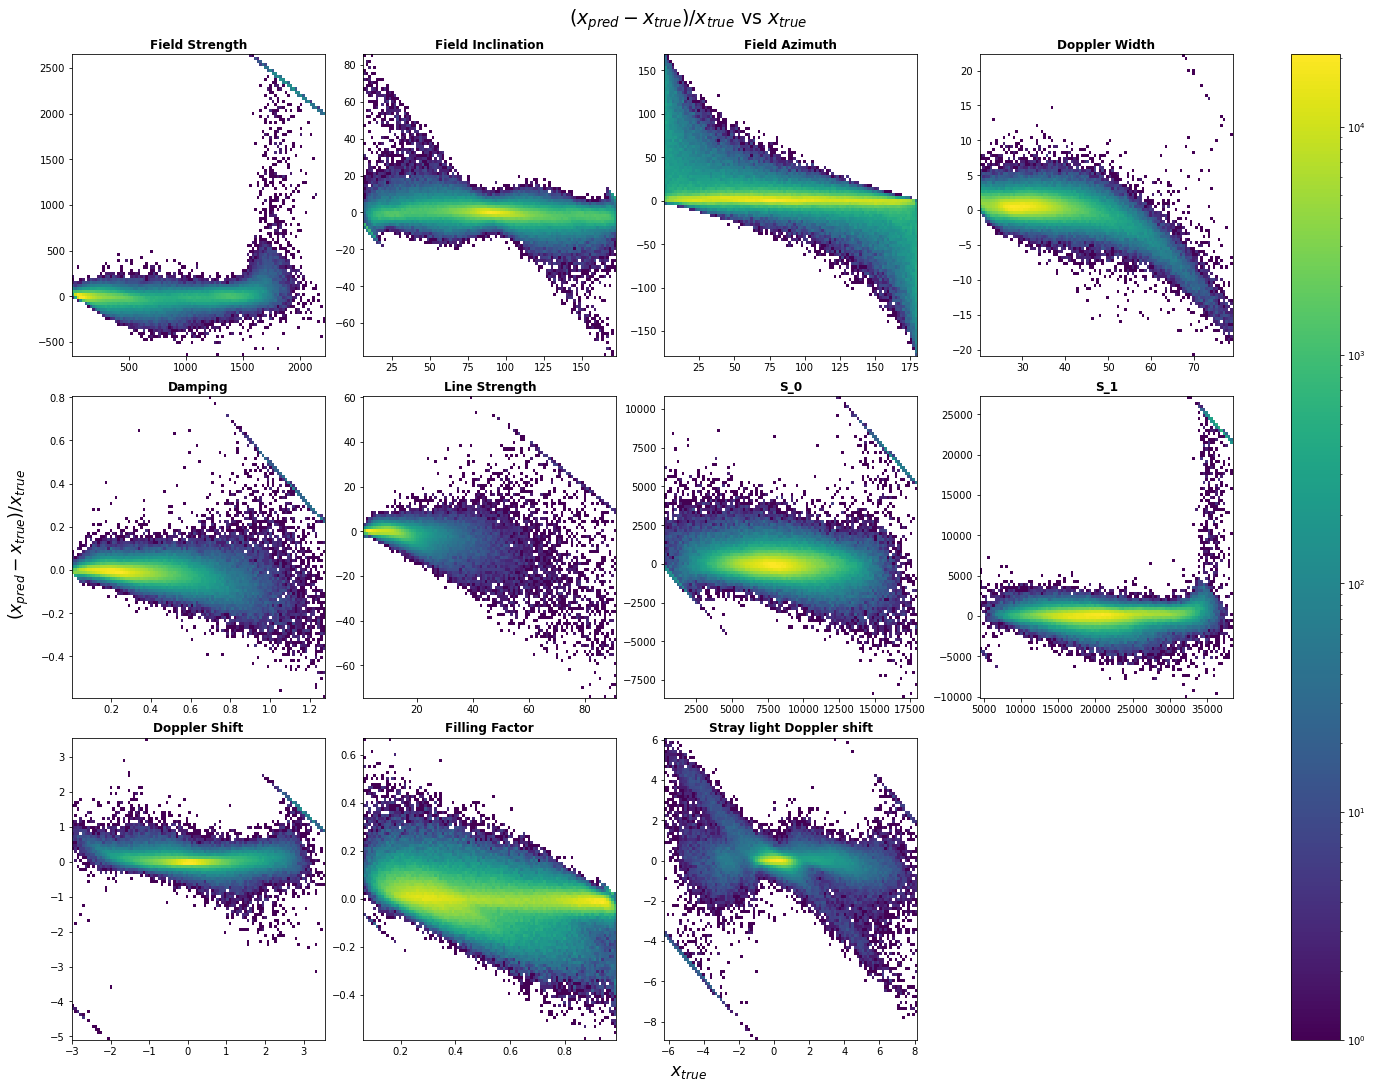

In [49]:
plot_analysis_hist2d(masked_ref_unnorm_2d.data, predicted_2d_inv, 
                     mask=masked_ref_2d.mask, 
                     save_path=save_path+model_name+'_analysis_hist2d_inv')

custom_xlim = (-0, 1)
# custom_ylim = (-1, 1)
plt.setp(axs, xlim=custom_xlim)

plt.show()

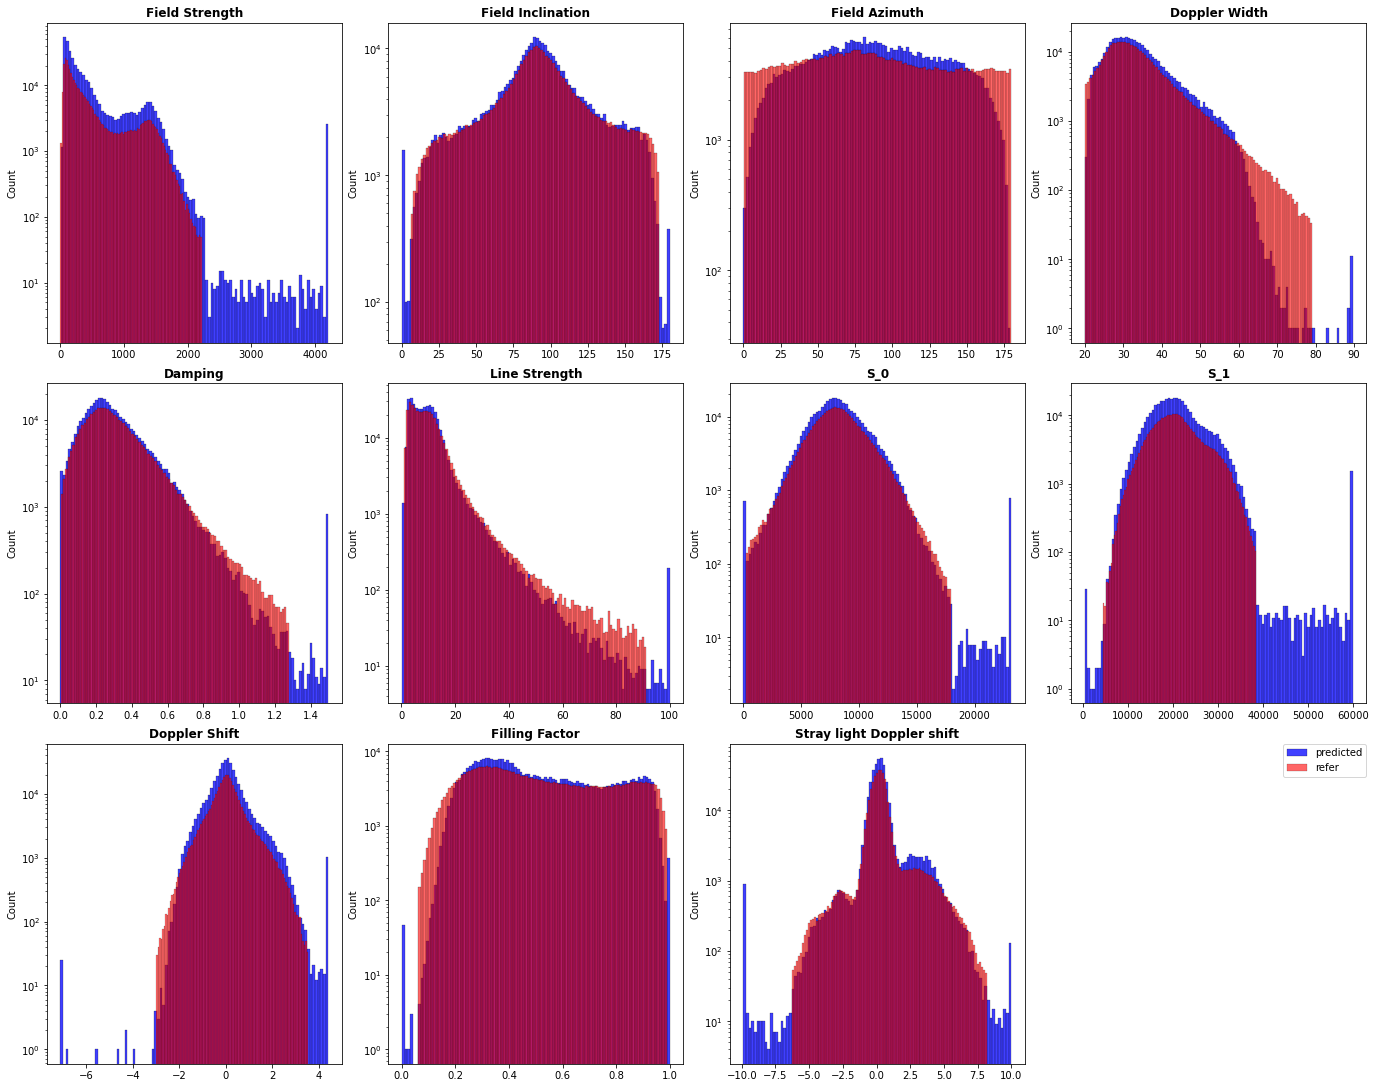

In [48]:
plot_hist_params_comparison(predicted_2d_inv, masked_ref_unnorm_2d.data, 
                            mask=masked_ref_2d.mask,
                            save_path=save_path+model_name+'_inv_comp_plot')
plt.show()

## Проверка на реальных спектрах

Спектры лежат в отдельной папочке sp_..... (много папочек в папочках, оставила так же как и лежит на хиноде). Спектры получаются последовательным сканированием щели, и результаты каждой в своем фитсе, всего 873, внутри каждой щели 512 спектров.

In [4]:
path_to_folder = '../data/hinode_source'
path_to_refer = '../data/hinode_source/20140926_170005.fits'

# date as a list with year, month,day, hour 
date = ['2014', '09', '26', '17']

sp_folder = os.path.join(path_to_folder, 'sp_20140926_170005')

sp_path = os.path.join(sp_folder, date[0], date[1], date[2], 'SP3D')
sp_path = glob.glob(f'{sp_path}/*/')[0]

sp_lines = sorted(glob.glob(sp_path + '*.fits'))
print(f'Number of files: {len(sp_lines)}')

Number of files: 873


In [5]:
refer, names = open_param_file(path_to_refer, print_params=False, normalize=False)

### Подготовка реальных спектров для модели

In [52]:
def prepare_real_conv(sp_folder, date, factors=None, cont_scale=None, device=None):
    real_samples, cont = read_spectrum_for_refer(sp_folder, date)
    norm_real_samples = normalize_spectrum(np.reshape(real_samples, (-1, 56, 4), order='F'),
                                           factors=factors)
    
    norm_cont = cont / cont_scale
    norm_real_samples = np.swapaxes(norm_real_samples, 1, 2)
    real_x = [torch.from_numpy(norm_real_samples).float().to(device), torch.from_numpy(norm_cont).float().to(device)]
    return real_x

In [54]:
%%time

transform = conv1d_transform_rescale(factors=factors, 
                                     angle_transformation=angle_transformation,
                                     cont_scale=cont_scale, logB=logB, QuantileTransformer=qt)

test_dataset = PregenSpectrumDataset(data_arr=refer.reshape(-1, 11),
                                     transform=transform)

inputs = test_dataset.samples
sim_x = [inputs['X'][0].to(device), inputs['X'][1].to(device)]

CPU times: user 31.9 s, sys: 4.31 s, total: 36.2 s
Wall time: 36.6 s


In [55]:
%%time

real_x = prepare_real_conv(sp_folder, date, factors=factors, cont_scale=cont_scale, device=device)

CPU times: user 4.07 s, sys: 1.81 s, total: 5.88 s
Wall time: 18.5 s


In [56]:
model.eval()
with torch.no_grad():
    predicted_real = model(real_x)

In [57]:
predicted_real = predicted_real.detach().cpu().numpy()
predicted_real_2d = predicted_real.reshape(-1, 11).copy()

In [58]:
np.save(save_path + 'predicted_real', predicted_real_2d)

In [59]:
inv_predicted_real_2d = qt.inverse_transform(predicted_real_2d)

In [70]:
np.save(save_path + 'predicted_real_inv', inv_predicted_real_2d)

In [60]:
compute_metrics(refer, inv_predicted_real_2d,
                save_path=save_path+model_name+'_inv_real' + '.csv')

,r2,mse,mae
Field Strength,0.7574,9.280220e+04,158.9433
Field Inclination,0.9241,1.076551e+02,5.9162
Field Azimuth,0.5967,1.012734e+03,17.8641
Doppler Width,0.2303,7.142160e+01,5.6713
Damping,0.2420,3.790000e-02,0.1334
Line Strength,0.1764,1.077397e+02,4.5311
S_0,0.1301,8.095391e+06,2011.1766
S_1,0.5445,1.854887e+07,3151.3733
Doppler Shift,0.4490,9.091000e-01,0.7993
Filling Factor,0.3174,5.720000e-02,0.1843


In [6]:
inv_predicted_real_2d = np.load('/Users/kgb/Downloads/predicted_real_inv.npy')

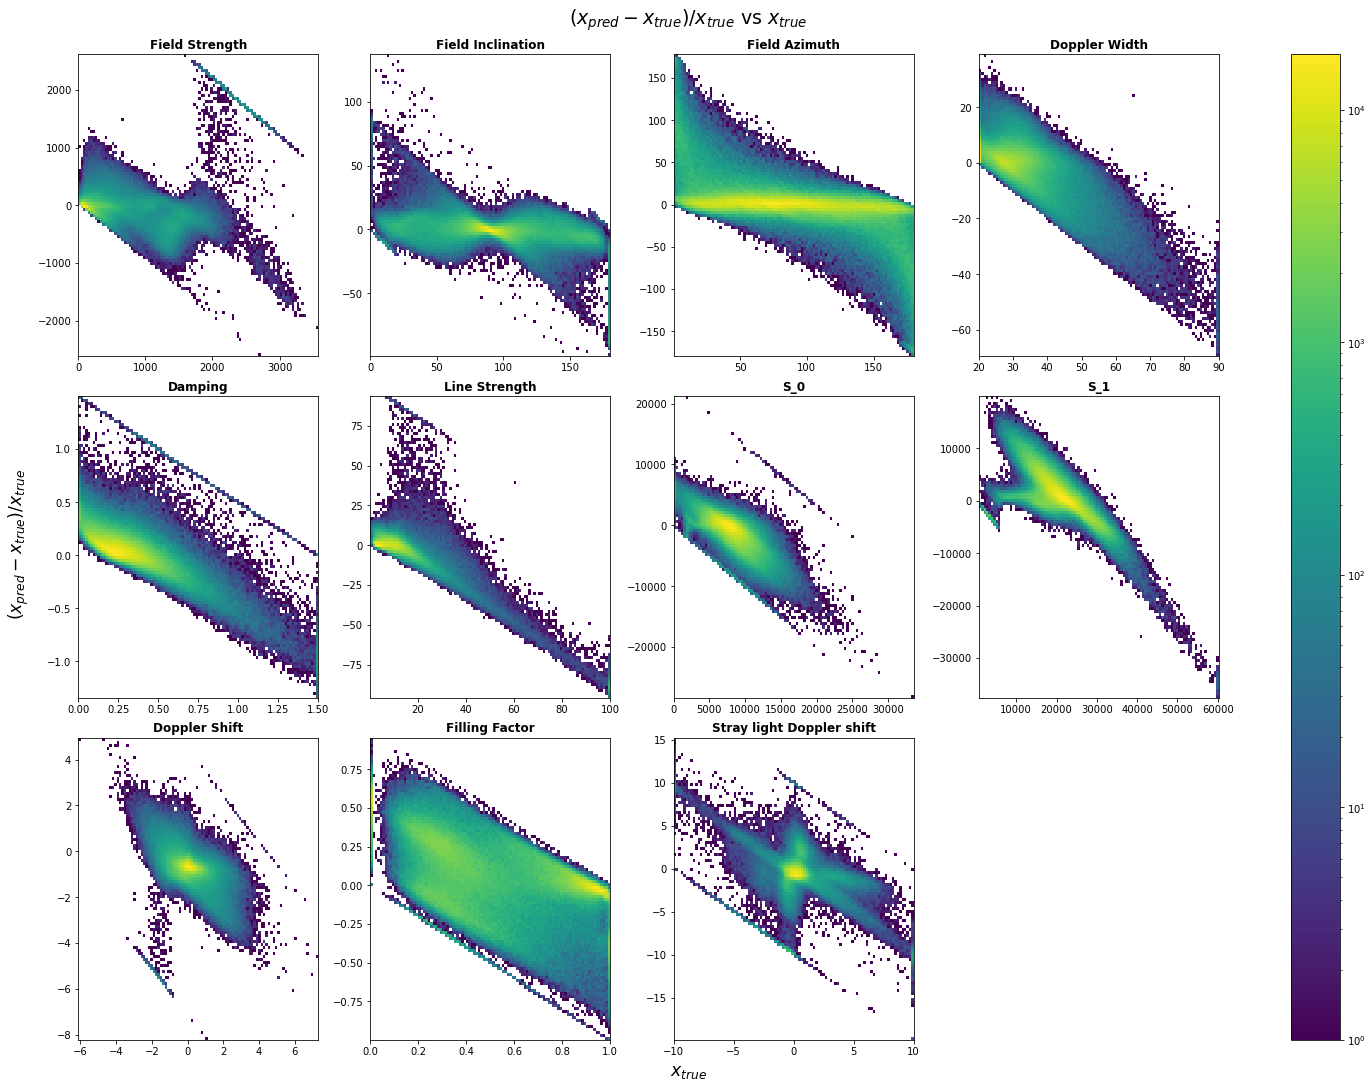

In [8]:
plot_analysis_hist2d(refer, inv_predicted_real_2d,
                     save_path=save_path+model_name+'_analysis_hist2d_real_inv')

plt.show()

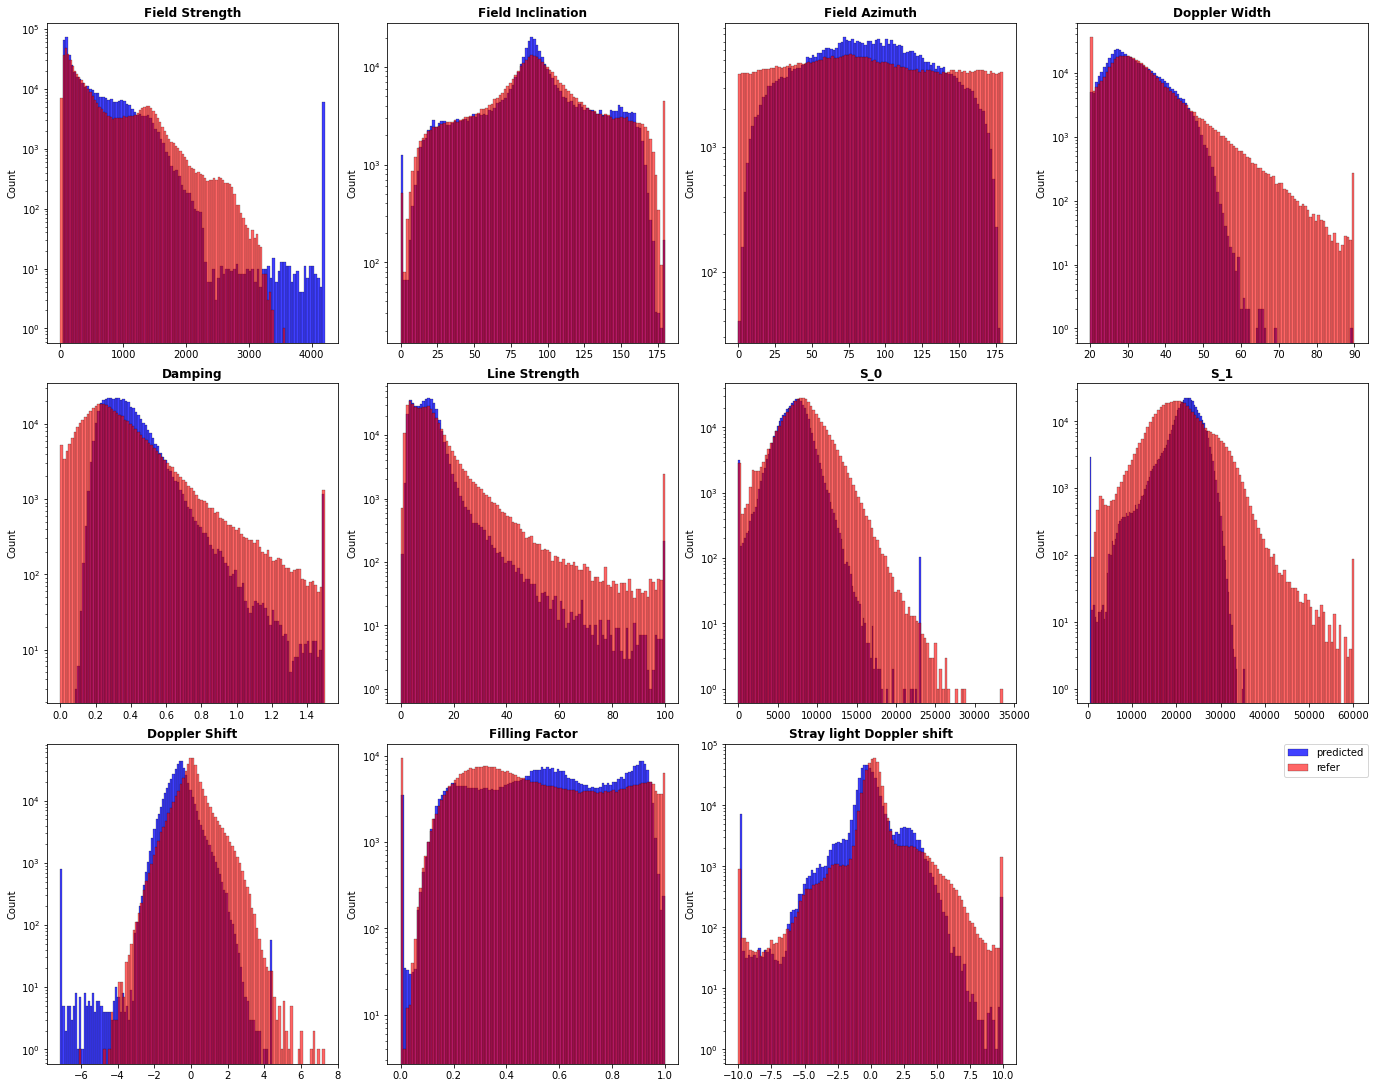

In [11]:
plot_hist_params_comparison(inv_predicted_real_2d, refer,
                            save_path=save_path+model_name+'_inv_real_comp_plot')

plt.show()